# Preparation for Data Analysis

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master('local') \
    .appName('Project Spotify') \
    .config("spark.executor.memory", '8g') \
    .config('spark.executor.cores', '4') \
    .config('spark.cores.max', '4') \
    .config("spark.driver.memory",'8g') \
    .getOrCreate()

sc = spark.sparkContext

In [2]:
import os
data_path = '/home/jovyan'
filename = 'spotify_data.csv'
path_to_data = os.path.join(data_path, filename)

In [3]:
df = spark.read.csv(path_to_data, header=True, inferSchema=True)

In [4]:
var_to_keep = [
    'track_id',
    'album_type',
    'release_date',
    'is_explicit',
    'track_popularity',
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
    'time_signature',
    'num_follower',
    'song_age'
]

genre = [x for x in df.columns if x not in var_to_keep]

In [5]:
len(var_to_keep)

20

In [6]:
len(genre)

91

In [7]:
var_to_use = [
    'album_type',
    'is_explicit',
    'track_popularity',
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
    'time_signature',
    'num_follower',
    'song_age'
]

In [8]:
final_df = df[var_to_use + genre]

In [9]:
label = 'track_popularity'
features = [x for x in final_df.columns if x != label]

In [10]:
# Convert time signature and album type from string to index
from pyspark.ml.feature import StringIndexer
tsIndexer = StringIndexer(inputCol='time_signature',outputCol='tsIndex')
albumTypeIndexer = StringIndexer(inputCol='album_type',outputCol='albumTypeIndex')

final_df = tsIndexer.fit(final_df).transform(final_df)
final_df = albumTypeIndexer.fit(final_df).transform(final_df)

In [11]:
# Ont-hot encoding for key, time signature and album type
from pyspark.ml.feature import OneHotEncoder
keyEncoder=OneHotEncoder(inputCol='key', outputCol='keyVec', dropLast=False)
tsEncoder = OneHotEncoder(inputCol='tsIndex', outputCol='tsVec', dropLast=False)
albumTypeEncoder = OneHotEncoder(inputCol="albumTypeIndex",outputCol="albumTypeVec", dropLast=False)

final_df = keyEncoder.transform(final_df)
final_df = tsEncoder.transform(final_df)
final_df = albumTypeEncoder.transform(final_df)

In [12]:
# Assign pitch class to each key index
pitch_class = {
    0:'C Key',
    1:'C#/Db Key',
    2:'D Key',
    3:'D#/Eb Key',
    4:'E Key',
    5:'F Key',
    6:'F#/Gb Key',
    7:'G Key',
    8:'G#/Ab Key',
    9:'A Key',
    10:'A#/Bb Key',
    11:'B Key'
}

In [13]:
# Map string index back to their own categories
tsDict = final_df.select('time_signature','tsIndex').distinct().sort('tsIndex').toPandas().to_dict('list')
albumTypeDict = final_df.select('album_type','albumTypeIndex').distinct().sort('albumTypeIndex').toPandas().to_dict('list')

In [14]:
# Create variables for each dummy variables
keyDummy = list(pitch_class.values())
tsDummy = ['time_signature_' + str(x) for x in tsDict['time_signature']]
albumTypeDummy = albumTypeDict['album_type']

In [15]:
# Detect the location of each item in the column name list
key_index = features.index('key')
time_signature_index = features.index('time_signature')
album_type_index = features.index('album_type')

In [16]:
# Update the columns list by replacing the categorical variable in reverse order
featureCol = features
featureCol = featureCol[:key_index] + keyDummy + featureCol[key_index+1:]
featureCol = featureCol[:time_signature_index] + tsDummy + featureCol[time_signature_index+1:]
featureCol = featureCol[:album_type_index] + albumTypeDummy + featureCol[album_type_index+1:]

In [17]:
len(featureCol)

125

In [18]:
# Remove all the unnecessary columns
from pyspark.sql.functions import *
final_df = final_df.withColumn('key', col('keyVec')) \
                    .withColumn('time_signature', col('tsVec')) \
                    .withColumn('album_type', col('albumTypeVec')) \
                    .drop('keyVec','tsVec','tsIndex','albumTypeVec','albumTypeIndex')

In [19]:
# Assemble all columns into one feature column
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols = features, outputCol = "features")
final_df = va.transform(final_df).select('features', col(label).alias('label'))

# Scale all variables in the feature vector
from pyspark.ml.feature import StandardScaler
ss = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
ssModel = ss.fit(final_df)
final_df = ssModel.transform(final_df).select(col('scaledFeatures').alias('features'), 'label')

In [21]:
# Sample 0.01 of the entire data for faster computation
theSeed = 314
sampled_df = final_df.sample(withReplacement=False, fraction=0.01, seed=theSeed)

In [22]:
# Split the sample data into train and test set
train_df, test_df = sampled_df.randomSplit([0.8,0.2], seed=theSeed)

In [23]:
# Cache training set
train_df.cache()

DataFrame[features: vector, label: int]

In [24]:
# Cache test set
test_df.cache()

DataFrame[features: vector, label: int]

In [25]:
# Check the count of training set
train_df.count()

4686

In [26]:
# Check the count of test set
test_df.count()

1174

# Modeling

In [27]:
# Define evaluators for regression metrics
from pyspark.ml.evaluation import RegressionEvaluator
rmse = RegressionEvaluator(predictionCol="prediction", metricName="rmse")
r2 = RegressionEvaluator(predictionCol="prediction", metricName="r2")
mae = RegressionEvaluator(predictionCol="prediction", metricName="mae")

In [28]:
# Define a function that compute relevant metrics
def model_performance(predictions):
    rmse_result = rmse.evaluate(predictions)
    r2_result = r2.evaluate(predictions)
    mae_result = mae.evaluate(predictions)
    return [rmse_result, r2_result, mae_result]

# Cross Validation

In [29]:
# Import models and cross validation packages
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor, GBTRegressor

## Principal Component Analysis

In [91]:
# Compute principal components
from pyspark.ml.feature import PCA
n_features = len(featureCol)
pca = PCA(k=n_features, inputCol='features', outputCol="pcaFeatures")
pca_model = pca.fit(final_df)
pca_df = pca_model.transform(final_df).select("pcaFeatures")

In [94]:
# Compute explained variance and the running total for each PC
pve = pca_model.explainedVariance
cpve = np.cumsum(pve)
pc = range(1,n_features + 1)

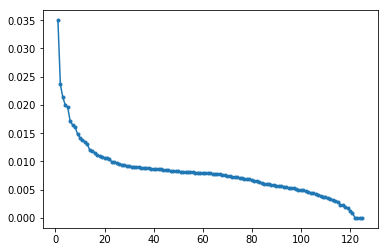

In [115]:
# Plot Percent of variance explained vs number of PC
plt.plot(pc, pve, marker='.')
plt.show()

In [109]:
# Check the quantile of variance explained by different number of PCs
explainedVar = np.linspace(0.1, 1.0, 10, endpoint=True)
minPC = [(cpve <= x).sum() for x in explainedVar]
pd.DataFrame({'explainedVar':explainedVar, 'minPC':minPC})

,explainedVar,minPC
0,0.1,4
1,0.2,10
2,0.3,18
3,0.4,28
4,0.5,39
5,0.6,51
6,0.7,63
7,0.8,77
8,0.9,93
9,1.0,124


In [118]:
# Compute the first 20 PCs
pca = PCA(k=20, inputCol='features', outputCol='pc')
pca_model = pca.fit(final_df)
final_df = pca_model.transform(final_df)

In [119]:
%%time
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(maxIter=10)
lr_model = lr.fit(train_df)
lr_predictions = lr_model.transform(test_df)

CPU times: user 21.7 ms, sys: 11.4 ms, total: 33.1 ms
Wall time: 621 ms


In [120]:
%%time
from pyspark.ml.regression import GeneralizedLinearRegression
glr = GeneralizedLinearRegression(maxIter=10)
glr_model = glr.fit(train_df)
glr_predictions = glr_model.transform(test_df)

CPU times: user 19 ms, sys: 11.7 ms, total: 30.7 ms
Wall time: 340 ms


In [121]:
%%time
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)

CPU times: user 33.6 ms, sys: 10.2 ms, total: 43.8 ms
Wall time: 2.28 s


In [122]:
%%time
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(numTrees=10)
rf_model = rf.fit(train_df)
rf_predictions = rf_model.transform(test_df)

CPU times: user 39.2 ms, sys: 18.5 ms, total: 57.8 ms
Wall time: 3.82 s


In [123]:
%%time
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)

CPU times: user 161 ms, sys: 55.9 ms, total: 217 ms
Wall time: 21.8 s


In [124]:
# Compute the performance for each model
lr_result = model_performance(lr_predictions)
glr_result = model_performance(glr_predictions)
dt_result = model_performance(dt_predictions)
rf_result = model_performance(rf_predictions)
gbt_result = model_performance(gbt_predictions)

In [125]:
# Compare the performance for each model
pd.DataFrame([lr_result,glr_result,dt_result,rf_result, gbt_result], \
             index=['lr', 'glr', 'dt', 'rf', 'gbt'], \
             columns=['rmse', 'r2', 'mae'])

,rmse,r2,mae
lr,9.457183,0.610708,7.332054
glr,9.457006,0.610722,7.332010
dt,11.896610,0.383974,9.456724
rf,11.673286,0.406885,9.502860
gbt,10.728685,0.498991,8.454744
